In [1]:
import pandas as pd
import numpy as np
import time
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import qgrid
warnings.filterwarnings('ignore')

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from string import ascii_uppercase
from numpy import random

In [2]:
db = np.loadtxt('../Frogs_MFCCs.data', delimiter = ',')
#Bufonidae - Rhinella - Rhinellagranulosa
#Dendrobatidae - Ameerega - Ameeregatrivittata
#Hylidae - 1.Dendropsophus, 2.Hypsiboas, 3.Osteocephalus, 4.Scinax - 1.HylaMinuta, 2.HypsiboasCinerascens, 2.HypsiboasCordobae, 3.OsteocephalusOophagus, 4.ScinaxRuber
#Leptodactylidae - 1.Adenomera, 2.Leptodactylus - 1.AdenomeraAndre, 1.AdenomeraHylaedactylus, 2.LeptodactylusFuscus

#Muestras
X = db[:, 0:22]

#Familias
Y = db[:, 22:25]

#Grupos
G = db[:, 25]

In [3]:
def classification_error(y_est, y_real):
    err = 0
    for y_e, y_r in zip(y_est, y_real):

        if y_e != y_r:
            err += 1

    return err/np.size(y_est)

def select_features(modelo, n_features, fwd, fltg):
    sfs = SFS(modelo, 
           k_features=n_features,
           forward=fwd,
           floating=fltg,
           verbose=1,
           scoring='accuracy',
           cv=5)
    
    return sfs

In [4]:
def seleccion(features):
    fwd = True
    fltg = False
        
    #Para calcular el costo computacional
    initial_time = time.time()
    
    sensitivity_array = np.zeros([4,10])
    efficiency_array = np.zeros([4])
    error = np.zeros(4)
    precision_array = np.zeros([4,10])
    fscore_array = np.zeros([4,10])
    TN_array = np.zeros([4])
    FP_array = np.zeros([4])
    FN_array = np.zeros([4])
    TP_array = np.zeros([4])
    
    #Implemetamos la metodología de validación 
    KNN = KNeighborsClassifier(n_neighbors = 1)
    
    for j in range(4):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y[:,2], test_size=0.25) # Modificar metodología de validación
        scaler = MinMaxScaler() #Escala entre 0 y 1
        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)

        sfs = select_features(KNN, features, fwd, fltg)
        sfs.fit(Xtrain, Ytrain)

        X_train_sfs = sfs.transform(Xtrain)
        X_test_sfs = sfs.transform(Xtest)
        X_features = sfs.transform(X)

        KNN.fit(X_train_sfs, Ytrain)
        Yest = KNN.predict(X_test_sfs)
        
        #code for calculating recall 
        sensitivity = recall_score(Ytest, Yest, average=None)
        sensitivity_array[j] = sensitivity

        #code for calculating accuracy 
        efficiency = accuracy_score(Ytest, Yest, normalize=True)
        efficiency_array[j] = efficiency

        #code for calculating precision 
        precision = precision_score(Ytest, Yest, average=None)
        precision_array[j] = precision

        #code for calculating f1 score 
        fscore = f1_score(Ytest, Yest, average=None)
        fscore_array[j] = fscore

        error[j] = classification_error(Yest, Ytest)
        
    print(sfs.k_feature_idx_)    
    return X_features, X_train_sfs, X_test_sfs, str(np.mean(efficiency_array)), str(np.std(efficiency_array)), str(np.mean(sensitivity_array)), str(np.std(sensitivity_array)), str(np.mean(precision_array)), str(np.std(precision_array)),  str(np.mean(fscore_array)), str(np.std(fscore_array)), str(np.mean(error)), str(np.std(error)), str(time.time()-initial_time)

In [12]:
pd.options.mode.chained_assignment = None

randn = np.random.randn
df_types = pd.DataFrame({'# de características seleccionadas' : pd.Series([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22])})
df_types["Eficiencia"] = ""
df_types["Int_Eficiencia"] = ""
df_types["Sensibilidad"] = ""
df_types["Int_Sensibilidad"] = ""
df_types["Precision"] = ""
df_types["Int_Precision"] = ""
df_types["F-Score"] = ""
df_types["Int_F-Score"] = ""
df_types["Error_Prueba"] = ""
df_types["Int_error"] = ""
df_types["Tiempo de ejecución"] = ""
df_types.set_index(['# de características seleccionadas'], inplace=True)

for k in df_types.index:
    XN, XtrainN, XtestN, efficiency, efficiency_interval, sensitivity, sensitivity_interval, precision, precision_interval, f, f_interval, error, std_error, tiempo = seleccion(k)
    print(k)
    df_types["Eficiencia"][k] = efficiency
    df_types["Int_Eficiencia"][k] = efficiency_interval
    df_types["Sensibilidad"][k] = sensitivity
    df_types["Int_Sensibilidad"][k] = sensitivity_interval
    df_types["Precision"][k] = precision
    df_types["Int_Precision"][k] = precision_interval
    df_types["F-Score"][k] = f
    df_types["Int_F-Score"][k] = f_interval
    df_types["Error_Prueba"][k] = error
    df_types["Int_error"][k] = std_error
    df_types["Tiempo de ejecución"][k] = tiempo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.2s finished
Features: 1/1[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.2s finished
Features: 1/1[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.2s finished
Features: 1/1[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.2s finished
Features: 1/1[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


(12,)
1


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.0s finished
Features: 1/2[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.8s finished
Features: 2/2[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.0s finished
Features: 1/2[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.7s finished
Features: 2/2[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.2s finished
Features: 1/2[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.9s finished
Features: 2/2[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs

(2, 12)
2


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.3s finished
Features: 1/3[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.7s finished
Features: 2/3[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.8s finished
Features: 3/3[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.0s finished
Features: 1/3[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.9s finished
Features: 2/3[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.8s finished
Features: 3/3[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs

(2, 12, 13)
3


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.2s finished
Features: 1/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.8s finished
Features: 2/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.9s finished
Features: 3/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    3.9s finished
Features: 4/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.1s finished
Features: 1/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.9s finished
Features: 2/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs

(2, 7, 12, 13)
4


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.1s finished
Features: 1/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.9s finished
Features: 2/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.8s finished
Features: 3/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.0s finished
Features: 4/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.8s finished
Features: 5/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.1s finished
Features: 1/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs

(2, 4, 12, 13, 21)
5


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.3s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.9s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.0s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    3.8s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.8s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.1s finished
Features: 6/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs

(1, 2, 7, 8, 12, 13)
6


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.2s finished
Features: 1/7[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.9s finished
Features: 2/7[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.9s finished
Features: 3/7[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.0s finished
Features: 4/7[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.8s finished
Features: 5/7[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    3.9s finished
Features: 6/7[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs

(1, 2, 6, 7, 10, 11, 14)
7


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.2s finished
Features: 1/8[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.8s finished
Features: 2/8[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.8s finished
Features: 3/8[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    3.8s finished
Features: 4/8[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.9s finished
Features: 5/8[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.0s finished
Features: 6/8[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs

(1, 2, 3, 4, 7, 11, 12, 21)
8


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.1s finished
Features: 1/9[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.9s finished
Features: 2/9[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.1s finished
Features: 3/9[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.1s finished
Features: 4/9[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.9s finished
Features: 5/9[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.1s finished
Features: 6/9[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs

(1, 2, 3, 4, 6, 9, 10, 13, 14)
9


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.1s finished
Features: 1/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.7s finished
Features: 2/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.8s finished
Features: 3/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    3.8s finished
Features: 4/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    4.1s finished
Features: 5/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.2s finished
Features: 6/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(

(1, 2, 3, 7, 8, 12, 13, 16, 17, 21)
10


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.2s finished
Features: 1/11[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.9s finished
Features: 2/11[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.8s finished
Features: 3/11[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    3.8s finished
Features: 4/11[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.9s finished
Features: 5/11[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.1s finished
Features: 6/11[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(

(1, 2, 3, 6, 7, 8, 11, 12, 13, 17, 21)
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    6.8s finished
Features: 1/12[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    7.0s finished
Features: 2/12[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.4s finished
Features: 3/12[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    6.6s finished
Features: 4/12[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    6.8s finished
Features: 5/12[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    6.9s finished
Features: 6/12[Parallel(

(1, 2, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21)
12


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.2s finished
Features: 1/13[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.8s finished
Features: 2/13[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.0s finished
Features: 3/13[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.1s finished
Features: 4/13[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.9s finished
Features: 5/13[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.0s finished
Features: 6/13[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(

[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.9s finished
Features: 12/13[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.9s finished
Features: 13/13[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


(1, 2, 3, 4, 6, 7, 8, 12, 13, 16, 17, 19, 21)
13


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.0s finished
Features: 1/14[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.7s finished
Features: 2/14[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.8s finished
Features: 3/14[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    3.8s finished
Features: 4/14[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.9s finished
Features: 5/14[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    3.9s finished
Features: 6/14[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.2s finished
Features: 9/14[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    4.2s finished
Features: 10/14[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    4.2s finished
Features: 11/14[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    4.1s finished
Features: 12/14[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.9s finished
Features: 13/14[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.7s finished
Features: 14/14[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


(1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 20, 21)
14


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.0s finished
Features: 1/15[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.8s finished
Features: 2/15[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.9s finished
Features: 3/15[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    3.9s finished
Features: 4/15[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    4.2s finished
Features: 5/15[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.9s finished
Features: 6/15[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(

[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.0s finished
Features: 6/15[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.0s finished
Features: 7/15[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.2s finished
Features: 8/15[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.1s finished
Features: 9/15[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    4.4s finished
Features: 10/15[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    4.3s finished
Features: 11/15[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Paralle

(1, 2, 3, 4, 6, 7, 8, 9, 12, 13, 14, 15, 18, 20, 21)
15


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.1s finished
Features: 1/16[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    4.0s finished
Features: 2/16[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.2s finished
Features: 3/16[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.2s finished
Features: 4/16[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    4.3s finished
Features: 5/16[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.3s finished
Features: 6/16[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.8s finished
Features: 3/16[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    6.1s finished
Features: 4/16[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    6.1s finished
Features: 5/16[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    6.6s finished
Features: 6/16[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    6.4s finished
Features: 7/16[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    6.5s finished
Features: 8/16[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(

(1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 20, 21)
16


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    6.8s finished
Features: 1/17[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    5.9s finished
Features: 2/17[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.0s finished
Features: 3/17[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    5.9s finished
Features: 4/17[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.8s finished
Features: 5/17[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    5.5s finished
Features: 6/17[Parallel(

Features: 16/17[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.7s finished
Features: 17/17[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.1s finished
Features: 1/17[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.8s finished
Features: 2/17[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.0s finished
Features: 3/17[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    3.9s finished
Features: 4/17[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    4.1s finished
Features

(0, 1, 2, 3, 4, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 21)
17


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.2s finished
Features: 1/18[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.8s finished
Features: 2/18[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.8s finished
Features: 3/18[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    3.9s finished
Features: 4/18[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.9s finished
Features: 5/18[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.2s finished
Features: 6/18[Parallel(

Features: 14/18[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.6s finished
Features: 15/18[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.3s finished
Features: 16/18[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.9s finished
Features: 17/18[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.6s finished
Features: 18/18[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.0s finished
Features: 1/18[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.8s finished
Featu

(0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 17, 18, 21)
18


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.2s finished
Features: 1/19[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.9s finished
Features: 2/19[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.1s finished
Features: 3/19[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.2s finished
Features: 4/19[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    4.1s finished
Features: 5/19[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.0s finished
Features: 6/19[Parallel(

Features: 12/19[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.8s finished
Features: 13/19[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.4s finished
Features: 14/19[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.2s finished
Features: 15/19[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.9s finished
Features: 16/19[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.6s finished
Features: 17/19[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s finished
Feat

(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 20, 21)
19


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.1s finished
Features: 1/20[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.7s finished
Features: 2/20[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.7s finished
Features: 3/20[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    3.8s finished
Features: 4/20[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.9s finished
Features: 5/20[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.0s finished
Features: 6/20[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    4.4s finished
Features: 11/20[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    4.2s finished
Features: 12/20[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.2s finished
Features: 13/20[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.8s finished
Features: 14/20[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.6s finished
Features: 15/20[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.3s finished
Features: 16/20[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Par

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21)
20


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    3.8s finished
Features: 1/21[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.4s finished
Features: 2/21[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.4s finished
Features: 3/21[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    3.6s finished
Features: 4/21[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.6s finished
Features: 5/21[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.1s finished
Features: 6/21[Parallel(

Features: 8/21[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.2s finished
Features: 9/21[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    4.3s finished
Features: 10/21[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    4.1s finished
Features: 11/21[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    4.0s finished
Features: 12/21[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.0s finished
Features: 13/21[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.8s finished
Featur

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21)
21


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.3s finished
Features: 1/22[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    4.0s finished
Features: 2/22[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.0s finished
Features: 3/22[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    3.9s finished
Features: 4/22[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.9s finished
Features: 5/22[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.1s finished
Features: 6/22[Parallel(

Features: 6/22[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.2s finished
Features: 7/22[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.1s finished
Features: 8/22[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.1s finished
Features: 9/22[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    4.2s finished
Features: 10/22[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    4.1s finished
Features: 11/22[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    4.0s finished
Features

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21)
22


NameError: name 'qgrid' is not defined

In [14]:
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)

In [15]:
qgrid_widget.get_changed_df()

,Eficiencia,Int_Eficiencia,Sensibilidad,Int_Sensibilidad,Precision,Int_Precision,F-Score,Int_F-Score,Error_Prueba,Int_error,Tiempo de ejecución
# de características seleccionadas,,,,,,,,,,,
1,0.5956086714841579,0.006926034349292422,0.274507148501245,0.2652515724433594,0.280302966787321,0.26629667006934876,0.27651994532068347,0.2656952293100926,0.40439132851584214,0.006926034349292461,17.401614904403687
2,0.7893274041133963,0.008566445251485522,0.5617622715085622,0.2371324882607293,0.5748050878006004,0.2247067207392206,0.5664824175555344,0.22969707004744896,0.21067259588660364,0.00856644525148552,32.5590033531189
3,0.8907726514730406,0.005620830577030786,0.7573730418547748,0.17040174318539286,0.7683850813675169,0.16569612266296574,0.7593405950903087,0.16439275685350724,0.10922734852695942,0.005620830577030763,48.28548979759216
4,0.9337131739855475,0.007165854966288878,0.8523078868005882,0.11206804741828356,0.8602353048173299,0.10087861511641019,0.8548654479740078,0.10294706318082951,0.06628682601445247,0.007165854966288904,64.10790610313416
5,0.9540022234574763,0.0057950693335167116,0.8872095088225092,0.09774340916135153,0.8817653887850252,0.11156157286524225,0.8829855614409393,0.10102545754412443,0.04599777654252363,0.005795069333516687,81.37392210960388
6,0.9695664257921067,0.006081255277109779,0.9295003906660941,0.06226586486623129,0.9310134530154197,0.06537043828406983,0.9291763516233985,0.05711087295820547,0.030433574207893277,0.0060812552771098,98.64397811889648
7,0.9749861033907726,0.005586367771606923,0.9412737076959713,0.05051959864974319,0.9410688669348687,0.07161750652756481,0.9396674615611351,0.0535155284176302,0.02501389660922735,0.005586367771606943,114.67767214775085
8,0.980544747081712,0.0020798540226647736,0.9513073845986106,0.06091777882832355,0.9568959473254584,0.06499662404725691,0.9536308213963011,0.060168850994381344,0.019455252918287938,0.00207985402266478,133.00140142440796
9,0.980544747081712,0.0020423761057113696,0.9487635190875444,0.05271813001615906,0.9598814266015797,0.04863718626581589,0.9534331893045092,0.04354074008628435,0.019455252918287938,0.0020423761057113765,148.81477785110474


In [5]:
X_features, XtrainN, XtestN, Acc, IntAcc, Sen, IntSen, Pre, IntPre, f, IntF, error, stdError, tiempo = seleccion(21)
print(error)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    3.5s finished
Features: 1/21[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.2s finished
Features: 2/21[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.3s finished
Features: 3/21[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    3.3s finished
Features: 4/21[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.4s finished
Features: 5/21[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    3.4s finished
Features: 6/21[Parallel(

Features: 8/21[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    3.6s finished
Features: 9/21[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.6s finished
Features: 10/21[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.5s finished
Features: 11/21[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.4s finished
Features: 12/21[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
Features: 13/21[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.2s finished
Featur

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21)
0.013618677042801557


In [6]:
X_features = X[:, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 21]]

## KNN (Cross-Validation)

The best model was KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform') 

Sensibilidad: 0.965496299138698 - Intervalo Sensibilidad: 0.045342989327401904 
Eficiencia: 0.986520289049472 - Intervalo Eficiencia: 0.0019405558704515234 
Precision: 0.9741360448762386 - Intervalo Precision: 0.03190391148599393 
F-Score: 0.9690754526393018 - Intervalo F-Score: 0.030548843844659734 
Error_Prueba: 0.013479710950528072 - Intervalo Error: 0.001940555870451493 
Tiempo ejecución: 53.49844694137573


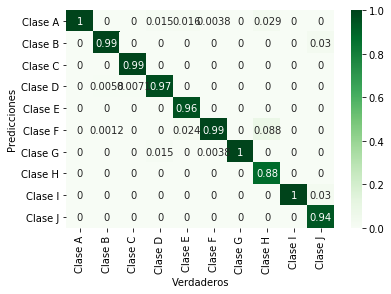

In [19]:
def KNN_model_CV(graficar = False):
    initial_time = time.time()
    sensitivity_array = np.zeros([4,10])
    efficiency_array = np.zeros([4])
    error = np.zeros(4)
    precision_array = np.zeros([4,10])
    fscore_array = np.zeros([4,10])
    TN_array = np.zeros([4])
    FP_array = np.zeros([4])
    FN_array = np.zeros([4])
    TP_array = np.zeros([4])   
    parameters = {'n_neighbors':(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20)}
    KNN = KNeighborsClassifier()
    clf = GridSearchCV(KNN, parameters)
    for j in range(4):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_features, Y[:,2], test_size=0.25)
        scaler = MinMaxScaler() #Escala entre 0 y 1
        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)

        clf.fit(Xtrain, Ytrain)
        Yest = clf.best_estimator_.predict(Xtest)

        #code for calculating recall 
        sensitivity = recall_score(Ytest, Yest, average=None)
        sensitivity_array[j] = sensitivity

        #code for calculating accuracy 
        efficiency = accuracy_score(Ytest, Yest, normalize=True)
        efficiency_array[j] = efficiency

        #code for calculating precision 
        precision = precision_score(Ytest, Yest, average=None)
        precision_array[j] = precision

        #code for calculating f1 score 
        fscore = f1_score(Ytest, Yest, average=None)
        fscore_array[j] = fscore

        #code for calculating confusion matrix 
        _confusion_matrix_ = confusion_matrix(Ytest, Yest)
        TN_array[j] = _confusion_matrix_[0][0]
        FP_array[j] = _confusion_matrix_[0][1]
        FN_array[j] = _confusion_matrix_[1][0]
        TP_array[j] = _confusion_matrix_[1][1]
                
        error[j] = classification_error(Yest, Ytest)
          
    if graficar == True:
        j = 0
        cm = confusion_matrix(Ytest, Yest, normalize='pred')
        columnas = ['Clase %s'%(i) for i in list(ascii_uppercase)[0:len(np.unique(Yest))]]
        df_cm = pd.DataFrame(cm,index = columnas, columns = columnas)
        grafica = sns.heatmap(df_cm, cmap = 'Greens', annot = True)
        grafica.set(xlabel = 'Verdaderos', ylabel = 'Predicciones')

    return clf.best_estimator_, str(np.mean(sensitivity_array)), str(np.std(sensitivity_array)), str(np.mean(efficiency_array)), str(np.std(efficiency_array)), str(np.mean(precision_array)), str(np.std(precision_array)),  str(np.mean(fscore_array)), str(np.std(fscore_array)), str(np.mean(error)), str(np.std(error)), str(time.time()-initial_time)

modelKNN, sensitivity, sensitivity_interval, efficiency, efficiency_interval, precision, precision_interval, f, f_interval, error, std_error, tiempo = KNN_model_CV(graficar = True)
print('The best model was', modelKNN,
        '\n\nSensibilidad:', sensitivity,'- Intervalo Sensibilidad:', sensitivity_interval,
        '\nEficiencia:', efficiency,'- Intervalo Eficiencia:', efficiency_interval,
        '\nPrecision:', precision,'- Intervalo Precision:', precision_interval,
        '\nF-Score:',f,'- Intervalo F-Score:', f_interval,
        '\nError_Prueba:',error,'- Intervalo Error:', std_error,
        '\nTiempo ejecución:', tiempo)

## Random Forest (Cross-Validation)

The best model was RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 

Sensibilidad: 0.9393260327228914 - Intervalo Sensibilidad: 0.0757411477799503 
Eficiencia: 0.9791550861589772 - Intervalo Eficiencia: 0.0040180189813232466 
Precision: 0.9610969678650948 - Intervalo Precision: 0.04141934305914831 
F-Score: 0.9482511021623724 - Intervalo F-Score: 0.04954045185421828 
Error_Prueba: 0.02084491384102279 - Intervalo Error: 0.004018018981323223 
Tiempo ejecución: 796.8236045837402


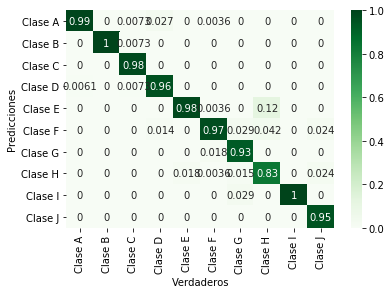

In [22]:
def RF_model_CV(graficar = False):
    initial_time = time.time()
    sensitivity_array = np.zeros([4,10])
    efficiency_array = np.zeros([4])
    error = np.zeros(4)
    precision_array = np.zeros([4,10])
    fscore_array = np.zeros([4,10])
    TN_array = np.zeros([4])
    FP_array = np.zeros([4])
    FN_array = np.zeros([4])
    TP_array = np.zeros([4])
    parameters = {'n_estimators':(5, 10, 20, 50, 100),
                 'max_features':(2, 5, 10, 13, 15, 19, 22)}
    RF = RandomForestClassifier()
    clf = GridSearchCV(RF, parameters, cv=5)
    for j in range(4):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_features, Y[:,2], test_size=0.25) # Modificar metodología de validación
        scaler = MinMaxScaler() #Escala entre 0 y 1
        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)

        clf.fit(Xtrain, Ytrain)
        Yest = clf.best_estimator_.predict(Xtest)

        #code for calculating recall 
        sensitivity = recall_score(Ytest, Yest, average=None)
        sensitivity_array[j] = sensitivity

        #code for calculating accuracy 
        efficiency = accuracy_score(Ytest, Yest, normalize=True)
        efficiency_array[j] = efficiency

        #code for calculating precision 
        precision = precision_score(Ytest, Yest, average=None)
        precision_array[j] = precision

        #code for calculating f1 score 
        fscore = f1_score(Ytest, Yest, average=None)
        fscore_array[j] = fscore

        #code for calculating confusion matrix 
        _confusion_matrix_ = confusion_matrix(Ytest, Yest)
        TN_array[j] = _confusion_matrix_[0][0]
        FP_array[j] = _confusion_matrix_[0][1]
        FN_array[j] = _confusion_matrix_[1][0]
        TP_array[j] = _confusion_matrix_[1][1]
                
        error[j] = classification_error(Yest, Ytest)
          
    if graficar == True:
        j = 0
        cm = confusion_matrix(Ytest, Yest, normalize='pred')
        columnas = ['Clase %s'%(i) for i in list(ascii_uppercase)[0:len(np.unique(Yest))]]
        df_cm = pd.DataFrame(cm,index = columnas, columns = columnas)
        grafica = sns.heatmap(df_cm, cmap = 'Greens', annot = True)
        grafica.set(xlabel = 'Verdaderos', ylabel = 'Predicciones')

    return clf.best_estimator_, str(np.mean(sensitivity_array)), str(np.std(sensitivity_array)), str(np.mean(efficiency_array)), str(np.std(efficiency_array)), str(np.mean(precision_array)), str(np.std(precision_array)),  str(np.mean(fscore_array)), str(np.std(fscore_array)), str(np.mean(error)), str(np.std(error)), str(time.time()-initial_time)

modelRF, sensitivity, sensitivity_interval, efficiency, efficiency_interval, precision, precision_interval, f, f_interval, error, std_error, tiempo = RF_model_CV(graficar = True)
print('The best model was', modelRF,
        '\n\nSensibilidad:', sensitivity,'- Intervalo Sensibilidad:', sensitivity_interval,
        '\nEficiencia:', efficiency,'- Intervalo Eficiencia:', efficiency_interval,
        '\nPrecision:', precision,'- Intervalo Precision:', precision_interval,
        '\nF-Score:',f,'- Intervalo F-Score:', f_interval,
        '\nError_Prueba:',error,'- Intervalo Error:', std_error,
        '\nTiempo ejecución:', tiempo)

## Maquinas de Soporte Vectorial con kernel lineal y con kernel RBF (Cross-Validation)

The best model was SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False) 

Sensibilidad: 0.9638898557622511 - Intervalo Sensibilidad: 0.053397106534018905 
Eficiencia: 0.9873540856031129 - Intervalo Eficiencia: 0.0007220889970409412 
Precision: 0.9719278688903795 - Intervalo Precision: 0.032184337210258554 
F-Score: 0.9670052021547967 - Intervalo F-Score: 0.037143385977690346 
Error_Prueba: 0.01264591439688716 - Intervalo Error: 0.0007220889970409435 
Tiempo ejecución: 1835.3170902729034


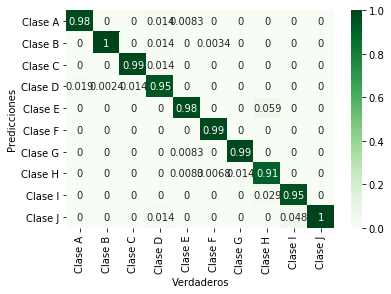

In [7]:
def SVC_model_CV(graficar = False):
    initial_time = time.time()
    sensitivity_array = np.zeros([4,10])
    efficiency_array = np.zeros([4])
    error = np.zeros(4)
    precision_array = np.zeros([4,10])
    fscore_array = np.zeros([4,10])
    TN_array = np.zeros([4])
    FP_array = np.zeros([4])
    FN_array = np.zeros([4])
    TP_array = np.zeros([4])
    parameters = {'kernel':('linear', 'rbf'),
                 'C':(0.001, 0.01, 0.1, 1, 10, 100, 200, 300),
                 'gamma':(0.001, 0.01, 0.1, 1)}
    SupportVC = SVC(decision_function_shape='ovo' , probability = True)
    clf = GridSearchCV(SupportVC, parameters)
    for j in range(4):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_features, Y[:,2], test_size=0.25) # Modificar metodología de validación
        scaler = MinMaxScaler() #Escala entre 0 y 1
        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)

        clf.fit(Xtrain, Ytrain)
        Yest = clf.best_estimator_.predict(Xtest)

        #code for calculating recall 
        sensitivity = recall_score(Ytest, Yest, average=None)
        sensitivity_array[j] = sensitivity

        #code for calculating accuracy 
        efficiency = accuracy_score(Ytest, Yest, normalize=True)
        efficiency_array[j] = efficiency

        #code for calculating precision 
        precision = precision_score(Ytest, Yest, average=None)
        precision_array[j] = precision

        #code for calculating f1 score 
        fscore = f1_score(Ytest, Yest, average=None)
        fscore_array[j] = fscore

        #code for calculating confusion matrix 
        _confusion_matrix_ = confusion_matrix(Ytest, Yest)
        TN_array[j] = _confusion_matrix_[0][0]
        FP_array[j] = _confusion_matrix_[0][1]
        FN_array[j] = _confusion_matrix_[1][0]
        TP_array[j] = _confusion_matrix_[1][1]
                
        error[j] = classification_error(Yest, Ytest)
          
    if graficar == True:
        j = 0
        cm = confusion_matrix(Ytest, Yest, normalize='pred')
        columnas = ['Clase %s'%(i) for i in list(ascii_uppercase)[0:len(np.unique(Yest))]]
        df_cm = pd.DataFrame(cm,index = columnas, columns = columnas)
        grafica = sns.heatmap(df_cm, cmap = 'Greens', annot = True)
        grafica.set(xlabel = 'Verdaderos', ylabel = 'Predicciones')

    return clf.best_estimator_, str(np.mean(sensitivity_array)), str(np.std(sensitivity_array)), str(np.mean(efficiency_array)), str(np.std(efficiency_array)), str(np.mean(precision_array)), str(np.std(precision_array)),  str(np.mean(fscore_array)), str(np.std(fscore_array)), str(np.mean(error)), str(np.std(error)), str(time.time()-initial_time)

modelSVC, sensitivity, sensitivity_interval, efficiency, efficiency_interval, precision, precision_interval, f, f_interval, error, std_error, tiempo = SVC_model_CV(graficar = True)
print('The best model was', modelSVC,
        '\n\nSensibilidad:', sensitivity,'- Intervalo Sensibilidad:', sensitivity_interval,
        '\nEficiencia:', efficiency,'- Intervalo Eficiencia:', efficiency_interval,
        '\nPrecision:', precision,'- Intervalo Precision:', precision_interval,
        '\nF-Score:',f,'- Intervalo F-Score:', f_interval,
        '\nError_Prueba:',error,'- Intervalo Error:', std_error,
        '\nTiempo ejecución:', tiempo)